# Mitral Valve Segmentation Project

This project was developed as part of the **Computer Vision Kaggle Competition**
at **ETH Zurich (AML 2025 – Project Task 2)**.  
Competition link: https://www.kaggle.com/competitions/eth-aml-2025-project-task-2

### Performance
- Public IoU score: **50.355%**
- Private IoU score: **52.312%**
- Final private leaderboard rank: **37th out of 99 teams**

### Contributors
- Lamberto Ragnolini (lragnolini@ethz.ch)
- Ivan Angjelovski (iangjelovski@ethz.ch)


## __SETUP__

In [1]:
import pickle
import gzip
import unet
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.ops import sigmoid_focal_loss
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import random
import cv2

/home/lamberto/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## __LOAD TRAINING DATA__

In [3]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [4]:
train_data = load_zipped_pickle('train.pkl')

## __EXTRACT LABELED FRAMES__

The idea is to develop the segmentation model through supervised Learning.

Every video has only 3 labeled frames (only 3 frames have the corresponding mask). 

We extract only the labeled frame to attempt training a UNet architecture uniquely on those. 

In [5]:
labeled_train_data = []

for sample in train_data:
    for i in sample['frames']:
        labeled_train_data.append({
            'name': sample['name'],
            'frame': sample['video'][:, :, i],          
            'label': sample['label'][:, :, i],
            'dataset': sample['dataset'],
            'box' : sample['box']
        })

print('Total labeled frames used for training', len(labeled_train_data))

Total labeled frames used for training 195


## __DATA AUGMENTATION__

In [6]:
from scipy.ndimage import gaussian_filter, map_coordinates

def elastic_deformation(image, mask, alpha=34, sigma=4):
    img_np = image.numpy() 
    mask_np = mask.numpy() 

    shape = img_np.shape  

    dx = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((np.random.rand(*shape) * 2 - 1), sigma) * alpha

    # NOTE: Meshgrid for coordinates
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = (y + dy).reshape(-1), (x + dx).reshape(-1)

    # NOTE: Apply deformation to frame
    deformed_img = map_coordinates(img_np, indices, order=1, mode='reflect').reshape(shape)

    # NOTE: Mask -> nearest neighbor to preserve labels
    deformed_mask = map_coordinates(mask_np, indices, order=0, mode='reflect').reshape(shape)

    deformed_img = torch.from_numpy(deformed_img)
    deformed_mask = torch.from_numpy(deformed_mask)

    return deformed_img, deformed_mask

In [7]:
import random
import cv2
import matplotlib.pyplot as plt

def augment_images(dataset):
    augmented = []

    for sample in dataset:
        augmented.append(sample)

        frame = torch.tensor(sample['frame'].copy()).float()
        mask  = torch.tensor(sample['label'].copy()).float()

        if random.random() > 0.5:
            augmented.append({
                **sample,
                'frame': torch.flip(frame, [-1]).numpy(),
                'label': torch.flip(mask,  [-1]).numpy()
            })

        if random.random() > 0.5:
            augmented.append({
                **sample,
                'frame': torch.flip(frame, [-2]).numpy(),
                'label': torch.flip(mask,  [-2]).numpy()
            })

        if random.random() > 0.5:
            f_aug, m_aug = elastic_deformation(frame, mask, alpha=34, sigma=4)
            augmented.append({
                **sample,
                'frame': f_aug.numpy(),
                'label': m_aug.numpy()
            })

        if random.random() > 0.5:
            f_aug = cv2.convertScaleAbs(
                frame.numpy(), alpha=1.5, beta=50
            )
            augmented.append({
                **sample,
                'frame': f_aug,
                'label': mask.numpy()
            })
        if random.random() > 0.5:
            f_np = frame.numpy().astype(np.uint8)
            f_aug = cv2.GaussianBlur(f_np, (5, 5), sigmaX=1.5)
            augmented.append({
                **sample,
                'frame': f_aug,
                'label': mask.numpy()
            })
            
        if random.random() > 0.5:
            f_aug = cv2.convertScaleAbs(
                frame.numpy(), alpha=0.6, beta=-10
            )
            augmented.append({
                **sample,
                'frame': f_aug,
                'label': mask.numpy()
            })
            # print(len(augmented))

    return augmented

dataset = augment_images(labeled_train_data)

## __UNet ARCHITECTURE__

In [44]:
class BaseConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(BaseConv, self).__init__()
        
        self.act = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x
    
class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DownConv, self).__init__()

        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv_block = BaseConv(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        x = self.pool1(x)
        x = self.conv_block(x)
        return x
    
class UpConv(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels, kernel_size, stride, padding):
        super(UpConv, self).__init__()

        self.conv_trans1 = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2, padding=0)
        self.conv_block = BaseConv(
            in_channels=in_channels + in_channels_skip,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding)

    def forward(self, x, x_skip):

        x = self.conv_trans1(x)

        x = torch.cat((x, x_skip), dim=1)
        x = self.conv_block(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_class, kernel_size, stride, padding, apply_sigmoid=True):
        super(UNet, self).__init__()
        self.n_class = n_class
        self.apply_sigmoid = apply_sigmoid

        self.init_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.down1 = DownConv(out_channels, 2 * out_channels, kernel_size, stride, padding)
        
        self.down2 = DownConv(2 * out_channels, 4 * out_channels, kernel_size, stride, padding)

        self.down3 = DownConv(4 * out_channels, 8 * out_channels, kernel_size, stride, padding)

        self.up3 = UpConv(8 * out_channels, 4 * out_channels, 4 * out_channels, kernel_size, stride, padding)

        self.up2 = UpConv(4 * out_channels, 2 * out_channels, 2 * out_channels, kernel_size, stride, padding)

        self.up1 = UpConv(2 * out_channels, out_channels, out_channels, kernel_size, stride, padding)

        self.out = nn.Conv2d(out_channels, n_class, kernel_size, stride, padding)
        
    def forward(self, x):
        # NOTE: Encoder
        x = self.init_conv(x)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        # NOTE: Decoder
        x_up = self.up3(x3, x2)
        x_up = self.up2(x_up, x1)
        x_up = self.up1(x_up, x)

        x_out = self.out(x_up)

        if self.n_class > 1:
            # NOTE: softmax for multi-object segmentation
            x_out = F.log_softmax(x_out, 1)
        else:
            # NOTE: for binary segmentation (background and
            #       object) we use sigmoid activation
            x_out = torch.sigmoid(x_out) if self.apply_sigmoid else x_out

        return x_out
 

## __DATASET PREPARATION AND DATALOADER INITIALIZATION__

In [32]:
from torch.utils.data import Dataset,DataLoader

class MitralDataset(Dataset):
    def __init__(self, samples, augment=False, target_size=(256,256)):
        self.samples = samples
        self.augment = augment
        self.target_size = target_size
    
    def __len__(self):
        return len(self.samples) * (2 if self.augment else 1)
    
    def __getitem__(self, idx):
        base_idx = idx % len(self.samples)

        item = self.samples[base_idx]

        frame = torch.tensor(item['frame']).float()
        mask  = torch.tensor(item['label']).float()

        # NOTE: Resize with padding to preserve aspect ratio
        frame, mask = self.resize_and_pad(frame, mask, self.target_size)
        frame = (frame - frame.mean()) / (frame.std() + 1e-6)

        return frame, mask
    
    def resize_and_pad(self, frame, mask, target_size):
        c, h, w = 1, frame.shape[-2], frame.shape[-1] 
        scale = min(target_size[0]/h, target_size[1]/w)
        new_h, new_w = int(h*scale), int(w*scale)

        frame_resized = F.interpolate(frame.unsqueeze(0).unsqueeze(0), size=(new_h, new_w), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
        mask_resized  = F.interpolate(mask.unsqueeze(0).unsqueeze(0), size=(new_h, new_w), mode='nearest').squeeze(0).squeeze(0)
        # print(frame_resized.shape)

        pad_h = target_size[0] - new_h
        pad_w = target_size[1] - new_w
        pad_top = pad_h // 2
        pad_bottom = pad_h - pad_top
        pad_left = pad_w // 2
        pad_right = pad_w - pad_left

        frame_padded = F.pad(frame_resized, (pad_left, pad_right, pad_top, pad_bottom))
        mask_padded  = F.pad(mask_resized,  (pad_left, pad_right, pad_top, pad_bottom))


        return frame_padded.unsqueeze(0), mask_padded.unsqueeze(0)


In [33]:
train_dataset = MitralDataset(dataset)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

## __*MODEL TRAINING*__

At the end the model that performed better was Unet compared to ResNet with attention.

In [ ]:
model = UNet(
    in_channels=1,
    out_channels=32,
    n_class=1,
    kernel_size=5,
    stride=1,
    padding=2,
    apply_sigmoid=False
)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 90
epoch_losses = []
model = model.cuda()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for frame,mask in train_loader:
        frame = frame.cuda()
        mask = mask.cuda()    
        optimizer.zero_grad()
        out = model(frame)
        loss = sigmoid_focal_loss(out,mask, reduction='mean')
        loss.backward()
        optimizer.step()
        running_loss += loss.item() 

    epoch_loss = running_loss / len(train_loader)
    
    if  epoch == 30:
        torch.save(model, 'Unet_30.pt')
    elif epoch == 40:
        torch.save(model, 'Unet_40.pt')
    elif epoch == 50:
        torch.save(model, 'Unet_50.pt')
    elif epoch == 60:
        torch.save(model, 'Unet_60.pt')
    elif epoch == 70:
        torch.save(model, 'Unet_70.pt')
    elif epoch == 80:
        torch.save(model, 'Unet_80.pt')
    elif epoch == 89:
        torch.save(model, 'Unet_90.pt')


    epoch_losses.append(epoch_loss)
    print(
        f"Epoch {epoch}: "
        f"loss={epoch_loss:.6f}, "
    )

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("FOCAL Loss")
plt.title("Training Focal Loss")
plt.grid(True)
plt.show() 


Epoch 0: loss=0.002918, 
Epoch 1: loss=0.001572, 
Epoch 2: loss=0.001367, 
Epoch 3: loss=0.001243, 
Epoch 4: loss=0.001187, 
Epoch 5: loss=0.001104, 
Epoch 6: loss=0.001089, 
Epoch 7: loss=0.001054, 
Epoch 8: loss=0.001019, 
Epoch 9: loss=0.000961, 
Epoch 10: loss=0.000914, 
Epoch 11: loss=0.000896, 
Epoch 12: loss=0.000876, 
Epoch 13: loss=0.000821, 
Epoch 14: loss=0.000809, 
Epoch 15: loss=0.000764, 
Epoch 16: loss=0.000864, 
Epoch 17: loss=0.000741, 
Epoch 18: loss=0.000685, 
Epoch 19: loss=0.000651, 
Epoch 20: loss=0.000622, 
Epoch 21: loss=0.000623, 
Epoch 22: loss=0.000618, 
Epoch 23: loss=0.000604, 
Epoch 24: loss=0.000522, 
Epoch 25: loss=0.000479, 
Epoch 26: loss=0.000448, 
Epoch 27: loss=0.000445, 
Epoch 28: loss=0.000428, 
Epoch 29: loss=0.000432, 
Epoch 30: loss=0.000361, 


KeyboardInterrupt: 

## __POSTPROCESSING AUXILLIARY FUNCTIONS__

This includes Morphological operations such as Dilation and Erosion and thresholding

In [9]:
def threshold_mask(pred, threshold):
    pred = pred.squeeze().detach().cpu()
    binary_mask = (pred > threshold).float()

    return binary_mask

def erode_mask(binary_mask, kernel_size=3, iterations=1):
    if binary_mask.dim() == 2:
        binary_mask = binary_mask.unsqueeze(0).unsqueeze(0)
    elif binary_mask.dim() == 3:
        binary_mask = binary_mask.unsqueeze(0)

    x = binary_mask
    for _ in range(iterations):

        x = 1 - F.max_pool2d(1 - x, kernel_size=kernel_size,stride=1,padding=kernel_size // 2)

    return x.squeeze()

def dilate_mask(binary_mask, kernel_size=3, iterations=1):
    if binary_mask.dim() == 2:
        binary_mask = binary_mask.unsqueeze(0).unsqueeze(0)
    elif binary_mask.dim() == 3:
        binary_mask = binary_mask.unsqueeze(0)

    x = binary_mask
    for _ in range(iterations):
        x = F.max_pool2d(x,kernel_size=kernel_size,stride=1,padding=kernel_size // 2)

    return x.squeeze()

## __SINGLE TRAINING FRAME SEGMENTATION CHECK__

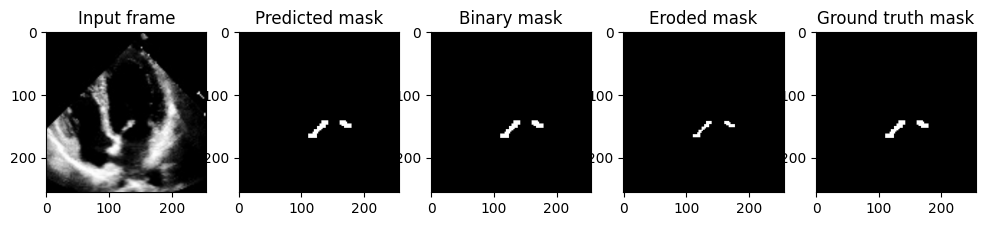

In [ ]:
model.eval()

frame, mask = train_dataset[120]     
frame_in = frame.cuda().unsqueeze(0)      

with torch.no_grad():

    pred = model(frame_in)         
    pred = torch.sigmoid(pred)     
    pred = pred.squeeze().cpu()    

binary_mask = threshold_mask(pred, threshold=0.1)
eroded_mask = erode_mask(binary_mask,kernel_size=3,   iterations=1)
plt.figure(figsize=(12,4))

plt.subplot(1,5,1)
plt.imshow(frame.squeeze(), cmap='gray')
plt.title("Input frame")

plt.subplot(1,5,2)
plt.imshow(pred, cmap='gray')
plt.title("Predicted mask")

plt.subplot(1,5,3)
plt.imshow(binary_mask, cmap='gray')
plt.title("Binary mask")

plt.subplot(1,5,4)
plt.imshow(eroded_mask, cmap='gray')
plt.title("Eroded mask")

plt.subplot(1,5,5)
plt.imshow(mask.squeeze(), cmap='gray')
plt.title("Ground truth mask")

plt.show()

# __EVALUATION METRICS ON TRAINING SET__

In [ ]:
def compute_iou(pred, true):
    pred = pred.bool()
    true = true.bool()
    
    intersection = (pred & true).sum().item()
    union = (pred | true).sum().item()

    if union == 0:
        return 1.0 if intersection == 0 else 0.0 

    return intersection / union


def compute_dice(pred, true):
    pred = pred.bool()
    true = true.bool()

    intersection = (pred & true).sum().item()
    total = pred.sum().item() + true.sum().item()

    if total == 0:
        return 1.0 if intersection == 0 else 0.0

    return 2 * intersection / total


def evaluate_model(model, dataloader, threshold=0.25):
    model.eval()

    results = []
    iou_scores = []
    dice_scores = []

    with torch.no_grad():
        for frames, masks in dataloader:
            frames = frames.cuda()
            masks= masks.cuda()

            logits = model(frames)
            probs  = torch.sigmoid(logits)

            for f, m, p in zip(frames, masks, probs):
                binary = threshold_mask(p, threshold)
                eroded = erode_mask(binary,kernel_size=3,iterations=1)
                dialated = dilate_mask(eroded, kernel_size=3, iterations=3) 

                true_mask = (m.squeeze().cpu() > 0.5).float()

                # NOTE: Checking with binary 
                iou  = compute_iou(binary, true_mask)
                dice = compute_dice(binary, true_mask)

                iou_scores.append(iou)
                dice_scores.append(dice)

                results.append({
                    "frame": f.cpu(),
                    "mask": true_mask,
                    "pred_prob": p.squeeze().cpu(),
                    "binary": binary,
                    "eroded": eroded,
                    "dialated" : dialated,
                    "iou": iou,
                    "dice": dice
                })

    avg_iou = sum(iou_scores) / len(iou_scores)
    avg_dice = sum(dice_scores) / len(dice_scores)

    return results, avg_iou, avg_dice

results, avg_iou, avg_dice = evaluate_model(model, train_loader, threshold=0.2)

print("Average IoU:", avg_iou)
print("Average Dice:", avg_dice)

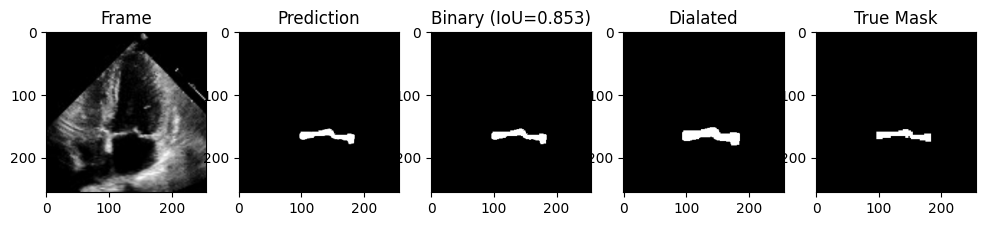

In [ ]:
sample = results[170]

plt.figure(figsize=(12,4))
plt.subplot(1,5,1); plt.imshow(sample["frame"].squeeze(), cmap='gray'); plt.title("Frame")
plt.subplot(1,5,2); plt.imshow(sample["pred_prob"], cmap='gray'); plt.title("Prediction")
plt.subplot(1,5,3); plt.imshow(sample["binary"], cmap='gray'); plt.title(f"Binary (IoU={sample['iou']:.3f})")
plt.subplot(1,5,4); plt.imshow(sample["eroded"], cmap='gray'); plt.title("Eroded")
plt.subplot(1,5,4); plt.imshow(sample["dialated"], cmap='gray'); plt.title("Dialated")
plt.subplot(1,5,5); plt.imshow(sample["mask"], cmap='gray'); plt.title("True Mask")
plt.show()


# __LOAD TEST DATA AND MODEL__

It is preferred to use the model that ran only on 30 epochs so that the masks segment the correct region where the valve is but are not very precise to then use morphological operations to make the masks tighter and fit the mitral valve correctly

In [10]:
test_data = load_zipped_pickle("test.pkl")

In [46]:
model_file = 'Unet_30_u.pt'
model = torch.load(model_file, weights_only=False)
model.eval()

UNet(
  (init_conv): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (down1): DownConv(
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block): BaseConv(
      (act): ReLU()
      (conv1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (down2): DownConv(
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block): BaseConv(
      (act): ReLU()
      (conv1): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (down3): DownConv(
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_block): BaseConv(
      (act): ReLU()
      (conv1): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv2)

## __SEGMENTATION AND GIF CREATION__

In [ ]:
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import imageio

THRESHOLD = 0.4
TARGET_SIZE = (256, 256)
DIR_NAME = 'Unet_30_th04_dilatedk5_erodedk5'

os.makedirs(DIR_NAME, exist_ok=True)

def overlay_mask(frame, mask, alpha=0.4):
    frame_norm = (frame - frame.min()) / (frame.max() - frame.min() + 1e-6)
    frame_rgb = np.stack([frame_norm]*3, axis=-1)

    overlay = frame_rgb.copy()
    overlay[..., 0] = np.maximum(overlay[..., 0], mask)  

    blended = (1 - alpha) * frame_rgb + alpha * overlay
    return (blended * 255).astype(np.uint8)


def resize_and_pad(frame, target_size):
    h, w = frame.shape
    scale = min(target_size[0] / h, target_size[1] / w)
    new_h, new_w = int(h * scale), int(w * scale)

    frame_resized = F.interpolate(frame.unsqueeze(0).unsqueeze(0),size=(new_h, new_w),mode="bilinear",align_corners=False).squeeze()

    pad_h = target_size[0] - new_h
    pad_w = target_size[1] - new_w
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left

    frame_padded = F.pad(frame_resized, (pad_left, pad_right, pad_top, pad_bottom))

    meta = {
        "orig_size": (h, w),
        "pad": (pad_top, pad_bottom, pad_left, pad_right)
    }
    return frame_padded, meta

def unpad_and_restore(mask, meta):
    pt, pb, pl, pr = meta["pad"]
    h, w = meta["orig_size"]

    unpadded = mask[pt:mask.shape[0]-pb, pl:mask.shape[1]-pr]
    restored = F.interpolate(unpadded.unsqueeze(0).unsqueeze(0),size=(h, w),mode="nearest").squeeze()

    return restored


def get_sequences(arr):
    arr = np.asarray(arr, dtype=np.uint8)
    arr = np.concatenate([[0], arr, [0]])
    diff = np.diff(arr)

    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]

    lengths = ends - starts
    return starts.tolist(), lengths.tolist()


ids, values = [], []
global_i = 0

model.eval()

with torch.no_grad():
    for sample in tqdm(test_data, desc="Processing videos"):
        name = sample["name"]
        video = sample["video"]  # NOTE: size here is (H, W, T)

        H, W, T = video.shape

        frames_gif = []


        # NOTE: Need to be a video-level mask!!!
        video_mask = np.zeros((H, W, T), dtype=np.uint8)

        for t in range(T):
            frame = torch.tensor(video[:, :, t]).float()

            # NOTE: Resize images the same as training
            frame_padded, meta = resize_and_pad(frame, TARGET_SIZE)
            frame_padded = (frame_padded - frame_padded.mean()) / (frame_padded.std() + 1e-6)
            frame_padded = frame_padded.cuda()

            # NOTE: Segmeent frames
            logits = model(frame_padded.unsqueeze(0).unsqueeze(0))
            probs = torch.sigmoid(logits).squeeze()

            # NOTE: Threshold mask
            binary = (probs > THRESHOLD).float()

            # NOTE: Morphological Operations
            dilated = dilate_mask(binary,kernel_size=5, iterations=1)
            eroded = erode_mask(dilated,kernel_size=5, iterations=1)

            # NOTE: Restore original size of every frame
            restored = unpad_and_restore(eroded, meta)
            restored = (restored > 0.5).cpu().numpy().astype(np.uint8)

            video_mask[:, :, t] = restored

            # NOTE: Overaly mask for the gif
            frame_np = frame.cpu().numpy()
            overlay = overlay_mask(frame_np, restored)
            frames_gif.append(overlay)


        # NOTE: Flatten everything and use get_sequences to get where the mask is in the flatten array for the submission
        flat = video_mask.flatten()
        starts, lengths = get_sequences(flat)

        gif_path = f"{DIR_NAME}/{name}.gif"
        imageio.mimsave(gif_path, frames_gif, fps=5)

        print(f"Saved GIF: {gif_path}")

        for s, l in zip(starts, lengths):
            ids.append(f"{name}_{global_i}")
            values.append([int(s), int(l)])
            global_i += 1



Processing videos:   0%|          | 0/20 [00:00<?, ?it/s]

Processing videos:   5%|▌         | 1/20 [00:10<03:15, 10.31s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/E9AHVWGBUF.gif


Processing videos:  10%|█         | 2/20 [00:15<02:06,  7.02s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/H7G0BX4HFV.gif


Processing videos:  15%|█▌        | 3/20 [00:21<01:54,  6.72s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/8FKMSXTPSJ.gif


Processing videos:  20%|██        | 4/20 [00:26<01:40,  6.28s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/JANFS05F33.gif


Processing videos:  25%|██▌       | 5/20 [00:32<01:31,  6.11s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/O7WUJ71C15.gif


Processing videos:  30%|███       | 6/20 [00:40<01:34,  6.72s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/1XHV0Q88M5.gif


Processing videos:  35%|███▌      | 7/20 [00:47<01:25,  6.60s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/401JD35E1A.gif
Saved GIF: Unet_30_th039_dilatedk5_erodedk5/VODEK84RH4.gif


Processing videos:  45%|████▌     | 9/20 [01:09<01:37,  8.91s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/ONA22CCCFQ.gif


Processing videos:  50%|█████     | 10/20 [01:19<01:33,  9.35s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/7UXIXUBK2G.gif


Processing videos:  55%|█████▌    | 11/20 [01:24<01:12,  8.02s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/ESY800XYMN.gif
Saved GIF: Unet_30_th039_dilatedk5_erodedk5/571G03ZYDA.gif


Processing videos:  65%|██████▌   | 13/20 [01:38<00:51,  7.31s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/QZA3WA0E2X.gif


Processing videos:  70%|███████   | 14/20 [01:44<00:41,  6.90s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/JQX264DTZ0.gif


Processing videos:  75%|███████▌  | 15/20 [01:48<00:30,  6.13s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/TYM0IJW004.gif


Processing videos:  80%|████████  | 16/20 [01:58<00:29,  7.28s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/CD4RIAOCHG.gif


Processing videos:  85%|████████▌ | 17/20 [02:08<00:23,  7.88s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/D271IBSMUW.gif


Processing videos:  90%|█████████ | 18/20 [02:12<00:13,  6.99s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/0MVRNDWR1G.gif


Processing videos:  95%|█████████▌| 19/20 [02:17<00:06,  6.13s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/1QSFD8ORNM.gif


Processing videos: 100%|██████████| 20/20 [02:22<00:00,  7.12s/it]

Saved GIF: Unet_30_th039_dilatedk5_erodedk5/UB7LFQKZT5.gif


## __CREATE SUBMISSION FILE__

In [ ]:
df = pd.DataFrame({
    "id": ids,
    "value": [str(v) for v in values]
})

submission = "prediction_Unet_30epoch_augmented_th04_dilatedk5_erodedk5.csv"
df.to_csv(submission, index=False)
    
print("prediction.csv saved correctly")
print("Total rows:", len(df))

prediction.csv saved correctly
Total rows: 1066351
